# Making stacked histograms
- processes an `events[year][ch][sample]` object using `make_events_dict()`
- uses `plot_hists()` to make stacked histograms

In [1]:
import glob
import os
import json
import pickle
import yaml
import math

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path
sys.path.append("../python/")

import utils

plt.rcParams.update({"font.size": 20})

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# get lumi
with open("../fileset/luminosity.json") as f:
    luminosity = json.load(f)
    
luminosity

{'ele': {'Run2': 137640.0,
  '2016APV': 19492.72,
  '2016': 16809.96,
  '2017': 41476.02,
  '2018': 59816.23},
 'mu': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'lep': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'had': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96}}

In [4]:
def get_lumi(years, channels):
    lum_ = 0
    for year in years:
        lum = 0
        for ch in channels:
            lum += luminosity[ch][year] / 1000.0

        lum_ += lum / len(channels)    
    return lum_

In [5]:
def rename_column(ev_dict, old_name, new_name):
    for year in ev_dict:
        for ch in ev_dict[year]:
            for sample in ev_dict[year][ch]:
                df = ev_dict[year][ch][sample]
                df[new_name] = df[old_name]
                
                # drop old column
                df = df[df.columns.drop(list(df.filter(regex=old_name)))]

# tagger_old = "fj_ParT_score_finetuned_v2_1-12"
# tagger_new = "fj_ParT_score_finetuned_v2_1_12"
# rename_column(events_dict, tagger_old, tagger_new)                

In [6]:
 # define your regions here
presel = {
        "mu": {
            "tagger>0.75": "fj_ParT_score_finetuned>0.75",
#             "msoftdrop": "fj_mass>40",
#             "met": "met_pt>35",            
        },
        "ele": {
            "tagger>0.75": "fj_ParT_score_finetuned>0.75",
#             "msoftdrop": "fj_mass>40",
#             "met": "met_pt>55",
            "lepmiso": "(lep_pt<120) | ( (lep_pt>120) & (lep_misolation<0.025))",            
        },
}

from make_stacked_hists_tagger import make_events_dict
channels = ["ele", "mu"]
# channels = ["ele"]
samples = [
    "ggF", 
    "VBF",  
    "WH",
    "ZH",    
    "ttH",
    "QCD",
    "WJetsLNu",
    "TTbar",
    "SingleTop",
    "Diboson",
    "EWKvjets",    
    "Data",
    "WZQQorDYJets"
]

samples_dir = {
    "2016":    "../eos/Feb9_2016",
    "2016APV": "../eos/Feb9_2016APV",
    "2017":    "../eos/Feb9_2017",
    "2018":    "../eos/Feb9_2018",    
}

years = ["2017", "2016", "2016APV", "2018"]
# years = ["2018"]

In [7]:
events_dict = {}

In [8]:
taggers = [
#     "v2_nor2",     # old signal samples (irreproducible)
    
#     "v35_12_14",     # new signal samples (more reproducible)

#     "v35_16",    # new signal samples (very reproducible) 15 epochs
#     "v35_17",    # new signal samples (very reproducible) 15 epochs
    
    "v35_20",    # new signal samples (very reproducible) 25 epochs
    "v35_23",    # new signal samples (very reproducible) 25 epochs
    "v35_26",    # new signal samples (very reproducible) 25 epochs
    "v35_29",    # new signal samples (very reproducible) 25 epochs
    
    
    # with in-memory
#     "v35_21",    # new signal samples (very reproducible)
#     "v35_22",    # new signal samples (very reproducible)
#     "v35_23",    # new signal samples (very reproducible)
    
    
#     "v35_24",    # new signal samples (very reproducible)
]


for year in years:
    out = make_events_dict([year], channels, samples_dir[year], samples, presel, taggers)
    events_dict = {**events_dict, **out}

INFO:root:Finding VBFHToWWToAny_M-125_TuneCP5_withDipoleRecoil samples and should combine them under VBF
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 1663 events
INFO:root:Applying lepmiso selection on 893 events
INFO:root:Will fill the VBF dataframe with the remaining 865 events
INFO:root:tot event weight 7.356228682484338 

INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 69 events
INFO:root:Applying lepmiso selection on 1 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 1 events
INFO:root:tot event weight 1.6639318904239442 

INFO:root:Finding EWKWminus_WToLNu samples and should combine them under EWKvjets
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 1897 events
INFO:root:Applying lepmiso selection on 156 events
INFO:root:Will fill the EWK

Skipping sample VBFHToWWToLNuQQ_M-125_withDipoleRecoil


INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 111882 events
INFO:root:Applying lepmiso selection on 10705 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 10412 events
INFO:root:tot event weight 563.4795137898067 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 355362 events
INFO:root:Applying lepmiso selection on 12268 events
INFO:root:Will fill the TTbar dataframe with the remaining 12023 events
INFO:root:tot event weight 1392.8602720504841 

INFO:root:Finding ST_t-channel_top_4f_InclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 23539 events
INFO:root:Applying lepmiso selection on 477 events
INFO:root:Will fill the SingleTop dataframe with the remaining 470 events
INFO:root:tot event weight

INFO:root:Finding WW samples and should combine them under Diboson
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 876 events
INFO:root:Applying lepmiso selection on 126 events
INFO:root:Will fill the Diboson dataframe with the remaining 123 events
INFO:root:tot event weight 58.30049603336026 

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-250To400 samples and should combine them under WZQQorDYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 530278 events
INFO:root:Applying lepmiso selection on 6136 events
INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 6021 events
INFO:root:tot event weight 30.75357034832752 

INFO:root:Finding ST_t-channel_antitop_4f_InclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 9552 events
INFO:root:Applying lepmiso selection on 200 events
INFO:root:W

INFO:root:tot event weight 0.9288805033870042 

INFO:root:Finding EWKWplus_WToLNu samples and should combine them under EWKvjets
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 1493 events
INFO:root:Applying lepmiso selection on 123 events
INFO:root:Will fill the EWKvjets dataframe with the remaining 120 events
INFO:root:tot event weight 50.748675042031344 

INFO:root:Finding GluGluZH_HToWW_M-125_TuneCP5_13TeV-powheg-pythia8 samples and should combine them under ZH
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 10580 events
INFO:root:Applying lepmiso selection on 5042 events
INFO:root:Will fill the ZH dataframe with the remaining 4904 events
INFO:root:tot event weight 0.06068053987283819 

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-0To50 samples and should combine them under WZQQorDYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 623 events
INFO:ro

Skipping sample VBFHToWWToLNuQQ_M-125_withDipoleRecoil


INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 148852 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 16937 events
INFO:root:tot event weight 924.0818434838249 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 375217 events
INFO:root:Will fill the TTbar dataframe with the remaining 14487 events
INFO:root:tot event weight 1665.402691790573 

INFO:root:Finding ST_t-channel_top_4f_InclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 34606 events
INFO:root:Will fill the SingleTop dataframe with the remaining 665 events
INFO:root:tot event weight 18.94925930821671 

INFO:root:Finding ST_s-channel_4f_hadronicDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored even

INFO:root:Will fill the TTbar dataframe with the remaining 3318 events
INFO:root:tot event weight 110.97422768327738 

INFO:root:Finding QCD_Pt_2400to3200 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 149 events
INFO:root:Will fill the QCD dataframe with the remaining 1 events
INFO:root:tot event weight 7.290023078177175e-05 

INFO:root:Finding EWKZ_ZToQQ samples and should combine them under EWKvjets
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 63 events
INFO:root:Will fill the EWKvjets dataframe with the remaining 5 events
INFO:root:tot event weight 0.19980917375406623 

INFO:root:Finding ZJetsToQQ_HT-400to600 samples and should combine them under WZQQorDYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 61 events
INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 1 events
INFO:root:tot 

INFO:root:tot event weight 0.06688511758275728 

INFO:root:Finding SingleMuon_Run2017F samples and should combine them under Data
INFO:root:Applying tagger>0.75 selection on 35806 events
INFO:root:Will fill the Data dataframe with the remaining 3206 events
INFO:root:tot event weight 3206.0 

INFO:root:Finding VBFHToWWToAny_M-125_TuneCP5_withDipoleRecoil samples and should combine them under VBF
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 784 events
INFO:root:Applying lepmiso selection on 406 events
INFO:root:Will fill the VBF dataframe with the remaining 389 events
INFO:root:tot event weight 2.9432430469927677 

INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 16 events
INFO:root:Applying lepmiso selection on 0 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 0 events
INFO:root:tot event 

Skipping sample VBFHToWWToLNuQQ_M-125_withDipoleRecoil


INFO:root:Applying lepmiso selection on 3527 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 3412 events
INFO:root:tot event weight 192.6208843894674 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 353131 events
INFO:root:Applying lepmiso selection on 12273 events
INFO:root:Will fill the TTbar dataframe with the remaining 12038 events
INFO:root:tot event weight 550.5644723414282 

INFO:root:Finding SingleElectron_Run2016G samples and should combine them under Data
INFO:root:Applying tagger>0.75 selection on 17638 events
INFO:root:Applying lepmiso selection on 1138 events
INFO:root:Will fill the Data dataframe with the remaining 1112 events
INFO:root:tot event weight 1112.0 

INFO:root:Finding ST_t-channel_top_4f_InclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying

INFO:root:tot event weight 14.030837072982777 

INFO:root:Finding ST_t-channel_antitop_4f_InclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 3760 events
INFO:root:Applying lepmiso selection on 76 events
INFO:root:Will fill the SingleTop dataframe with the remaining 72 events
INFO:root:tot event weight 2.0162933134062047 

INFO:root:Finding TTTo2L2Nu samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 64280 events
INFO:root:Applying lepmiso selection on 1813 events
INFO:root:Will fill the TTbar dataframe with the remaining 1777 events
INFO:root:tot event weight 49.29270547666751 

INFO:root:Finding QCD_Pt_2400to3200 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 229 events
INFO:root:Applying lepmiso selection on 

INFO:root:Applying lepmiso selection on 32 events
INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 32 events
INFO:root:tot event weight 6.947024118818148 

INFO:root:Finding WJetsToQQ_HT-400to600 samples and should combine them under WZQQorDYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 33 events
INFO:root:Applying lepmiso selection on 4 events
INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 4 events
INFO:root:tot event weight 6.04728775914425 

INFO:root:Finding WJetsToLNu_HT-400To600 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 11726 events
INFO:root:Applying lepmiso selection on 1173 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 1154 events
INFO:root:tot event weight 600.2161471483249 

INFO:root:Finding QCD_Pt_470to600 samples and should combine them under QCD
INFO:root:---> Using

Skipping sample VBFHToWWToLNuQQ_M-125_withDipoleRecoil


INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 60046 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 6501 events
INFO:root:tot event weight 369.11155447943696 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 393726 events
INFO:root:Will fill the TTbar dataframe with the remaining 16304 events
INFO:root:tot event weight 726.7629287596505 

INFO:root:Finding SingleElectron_Run2016G samples and should combine them under Data
INFO:root:Finding ST_t-channel_top_4f_InclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 16348 events
INFO:root:Will fill the SingleTop dataframe with the remaining 337 events
INFO:root:tot event weight 8.661147124890189 

INFO:root:Finding ST_s-channel_4f_hadronicDecays samp

INFO:root:tot event weight 3.0038324867197836 

INFO:root:Finding ZZ samples and should combine them under Diboson
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 32 events
INFO:root:Will fill the Diboson dataframe with the remaining 5 events
INFO:root:tot event weight 1.1873662083638925 

INFO:root:Finding TTToHadronic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 1629 events
INFO:root:Will fill the TTbar dataframe with the remaining 104 events
INFO:root:tot event weight 6.4265194130236925 

INFO:root:Finding QCD_Pt_1000to1400 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 1233 events
INFO:root:Will fill the QCD dataframe with the remaining 39 events
INFO:root:tot event weight 0.2703636396933868 

INFO:root:Finding QCD_Pt_600to800 samples and should combine them un

INFO:root:Will fill the EWKvjets dataframe with the remaining 81 events
INFO:root:tot event weight 21.41917325156219 

INFO:root:Finding EWKZ_ZToNuNu samples and should combine them under EWKvjets
INFO:root:Finding HWminusJ_HToWW_M-125 samples and should combine them under WH
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 1032 events
INFO:root:Applying lepmiso selection on 459 events
INFO:root:Will fill the WH dataframe with the remaining 445 events
INFO:root:tot event weight 0.3412983030591 

INFO:root:Finding WJetsToLNu_HT-800To1200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight


Skipping sample VBFHToWWToLNuQQ_M-125_withDipoleRecoil


INFO:root:Applying tagger>0.75 selection on 50985 events
INFO:root:Applying lepmiso selection on 4327 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 4209 events
INFO:root:tot event weight 216.35166792194488 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 326351 events
INFO:root:Applying lepmiso selection on 11927 events
INFO:root:Will fill the TTbar dataframe with the remaining 11703 events
INFO:root:tot event weight 612.9850706137383 

INFO:root:Finding ST_t-channel_top_4f_InclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 9112 events
INFO:root:Applying lepmiso selection on 172 events
INFO:root:Will fill the SingleTop dataframe with the remaining 167 events
INFO:root:tot event weight 5.669028012879451 

INFO:root:Finding ST_s-channel_4

INFO:root:tot event weight 53.216764523340686 

INFO:root:Finding QCD_Pt_2400to3200 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 231 events
INFO:root:Applying lepmiso selection on 1 events
INFO:root:Will fill the QCD dataframe with the remaining 1 events
INFO:root:tot event weight 3.373365250943315e-05 

INFO:root:Finding SingleElectron_Run2016E_HIPM samples and should combine them under Data
INFO:root:Applying tagger>0.75 selection on 8612 events
INFO:root:Applying lepmiso selection on 638 events
INFO:root:Will fill the Data dataframe with the remaining 624 events
INFO:root:tot event weight 624.0 

INFO:root:Finding EWKZ_ZToQQ samples and should combine them under EWKvjets
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 48 events
INFO:root:Applying lepmiso selection on 3 events
INFO:root:Will fill the EWKvjets dataframe with the remaining 3 events
INFO

INFO:root:Finding GluGluZH_HToWW_M-125_TuneCP5_13TeV-powheg-pythia8 samples and should combine them under ZH
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 4863 events
INFO:root:Applying lepmiso selection on 2230 events
INFO:root:Will fill the ZH dataframe with the remaining 2171 events
INFO:root:tot event weight 0.023388342649782623 

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-0To50 samples and should combine them under WZQQorDYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 344 events
INFO:root:Applying lepmiso selection on 30 events
INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 30 events
INFO:root:tot event weight 3.267740026070832 

INFO:root:Finding WJetsToQQ_HT-400to600 samples and should combine them under WZQQorDYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 44 events
INFO:root:Applying lepmiso selection on 3 even

Skipping sample VBFHToWWToLNuQQ_M-125_withDipoleRecoil


INFO:root:Applying tagger>0.75 selection on 73854 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 8128 events
INFO:root:tot event weight 422.1118076703211 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 368486 events
INFO:root:Will fill the TTbar dataframe with the remaining 16282 events
INFO:root:tot event weight 849.6933521106598 

INFO:root:Finding ST_t-channel_top_4f_InclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 13314 events
INFO:root:Will fill the SingleTop dataframe with the remaining 288 events
INFO:root:tot event weight 8.756387002088568 

INFO:root:Finding ST_s-channel_4f_hadronicDecays samples and should combine them under SingleTop
INFO:root:Finding WJetsToLNu_HT-1200To2500 samples and should combine them under WJetsLNu
I

INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 1 events
INFO:root:tot event weight 0.3375686722109401 

INFO:root:Finding ZZ samples and should combine them under Diboson
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 37 events
INFO:root:Will fill the Diboson dataframe with the remaining 3 events
INFO:root:tot event weight 0.7871090492191914 

INFO:root:Finding TTToHadronic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 1921 events
INFO:root:Will fill the TTbar dataframe with the remaining 146 events
INFO:root:tot event weight 7.917831446458759 

INFO:root:Finding QCD_Pt_1000to1400 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 1127 events
INFO:root:Will fill the QCD dataframe with the remaining 50 events
INFO:root:tot event weight 0.3583079279234

INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 414 events
INFO:root:Will fill the Diboson dataframe with the remaining 72 events
INFO:root:tot event weight 7.67318026995546 

INFO:root:Finding QCD_Pt_1400to1800 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 773 events
INFO:root:Will fill the QCD dataframe with the remaining 20 events
INFO:root:tot event weight 0.02046223831899215 

INFO:root:Finding SingleElectron_Run2016B_ver2_HIPM samples and should combine them under Data
INFO:root:Finding VBFHToWWToAny_M-125_TuneCP5_withDipoleRecoil samples and should combine them under VBF
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 1514 events
INFO:root:Applying lepmiso selection on 800 events
INFO:root:Will fill the VBF dataframe with the remaining 779 events
INFO:root:tot event weight 10.20690958494867 

INFO:root:

Skipping sample VBFHToWWToLNuQQ_M-125_withDipoleRecoil


INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 159607 events
INFO:root:Applying lepmiso selection on 14788 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 14360 events
INFO:root:tot event weight 795.3422682415899 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 349864 events
INFO:root:Applying lepmiso selection on 12093 events
INFO:root:Will fill the TTbar dataframe with the remaining 11882 events
INFO:root:tot event weight 1953.4769957045814 

INFO:root:Finding ST_t-channel_top_4f_InclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 31158 events
INFO:root:Applying lepmiso selection on 587 events
INFO:root:Will fill the SingleTop dataframe with the remaining 576 events
INFO:root:tot event weight

INFO:root:Finding QCD_Pt_2400to3200 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 222 events
INFO:root:Applying lepmiso selection on 0 events
INFO:root:Will fill the QCD dataframe with the remaining 0 events
INFO:root:tot event weight 0.0 

INFO:root:Finding EWKZ_ZToQQ samples and should combine them under EWKvjets
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 1 events
INFO:root:Applying lepmiso selection on 0 events
INFO:root:Will fill the EWKvjets dataframe with the remaining 0 events
INFO:root:tot event weight 0.0 

INFO:root:Finding ZJetsToQQ_HT-400to600 samples and should combine them under WZQQorDYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 47 events
INFO:root:Applying lepmiso selection on 1 events
INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 1 events
INFO:root:tot event w

INFO:root:Will fill the ZH dataframe with the remaining 6521 events
INFO:root:tot event weight 0.08378940004138491 

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-0To50 samples and should combine them under WZQQorDYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 885 events
INFO:root:Applying lepmiso selection on 86 events
INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 86 events
INFO:root:tot event weight 28.16384170244597 

INFO:root:Finding SingleMuon_Run2018C samples and should combine them under Data
INFO:root:Finding WJetsToQQ_HT-400to600 samples and should combine them under WZQQorDYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 58 events
INFO:root:Applying lepmiso selection on 6 events
INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 6 events
INFO:root:tot event weight 17.46277740471124 

INFO:root:Finding SingleMuon_Run2018D samples and should comb

Skipping sample VBFHToWWToLNuQQ_M-125_withDipoleRecoil


INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 210651 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 23979 events
INFO:root:tot event weight 1364.7150582419636 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 366309 events
INFO:root:Will fill the TTbar dataframe with the remaining 14342 events
INFO:root:tot event weight 2401.5412979227453 

INFO:root:Finding ST_t-channel_top_4f_InclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 44464 events
INFO:root:Will fill the SingleTop dataframe with the remaining 872 events
INFO:root:tot event weight 27.888970460584137 

INFO:root:Finding ST_s-channel_4f_hadronicDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored e

INFO:root:Finding ZZ samples and should combine them under Diboson
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 129 events
INFO:root:Will fill the Diboson dataframe with the remaining 18 events
INFO:root:tot event weight 4.696448154785337 

INFO:root:Finding TTToHadronic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 1386 events
INFO:root:Will fill the TTbar dataframe with the remaining 117 events
INFO:root:tot event weight 24.718927588827963 

INFO:root:Finding QCD_Pt_1000to1400 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.75 selection on 1111 events
INFO:root:Will fill the QCD dataframe with the remaining 39 events
INFO:root:tot event weight 0.8835903523942897 

INFO:root:Finding QCD_Pt_600to800 samples and should combine them under QCD
INFO:root:---> Using already stored eve

INFO:root:Applying tagger>0.75 selection on 16683 events
INFO:root:Will fill the Data dataframe with the remaining 1474 events
INFO:root:tot event weight 1474.0 



In [9]:
taggerss = ["fj_ParT_score"]
for tagger in taggers:
    taggerss.append(f"fj_ParT_score_finetuned_{tagger}")

In [10]:
signals = ["VBF", "ggF"]
# signals += ["ttH", "WH", "ZH"]

# tagger_cuts = np.linspace(0.8, 0.97, 30)
tagger_cuts = np.linspace(0.8, 1, 61)

years = ["2017", "2018", "2016", "2016APV"]
# years = ["2018"]
channels = ["ele", "mu"]
# channels = ["ele"]

s_over_b = {}

den, num = 0, 0

taggers_to_plot = [
    "fj_ParT_score",
#     "fj_ParT_score_finetuned",
#     "fj_ParT_score_finetuned_v35_12_14",
    
#     "fj_ParT_score_finetuned_v35_16",
#     "fj_ParT_score_finetuned_v35_17",
#     "fj_ParT_score_finetuned_v35_20",    
    
#     "fj_ParT_score_finetuned_v35_23",
    "fj_ParT_score_finetuned_v35_26",
#     "fj_ParT_score_finetuned_v35_29",
    
#     "fj_ParT_score_finetuned_v35_24",
    

#     "fj_ParT_score_finetuned_v35_12_14 metcut",

#     "fj_ParT_score_finetuned_v35_12_14 met>25",
#     "fj_ParT_score_finetuned_v35_12_14 met>30",
#     "fj_ParT_score_finetuned_v35_12_14 met>35",
#     "fj_ParT_score_finetuned_v35_12_14 met>40",
#     "fj_ParT_score_finetuned_v35_12_14 met>45",
#     "fj_ParT_score_finetuned_v35_12_14 met>50",
#     "fj_ParT_score_finetuned_v35_12_14 met>55",
#     "fj_ParT_score_finetuned_v35_12_14 met>60",    
]

add_vbfcut = 0
add_ggFcut = 0

for tagger in taggers_to_plot:
        
    print("TAGGER:", tagger)
    s_over_b[tagger] = []

    for tagger_cut in tagger_cuts[:-3]:
        print("tagger cut", tagger_cut)
        s, b = 0, 0
        for year in years:
            for ch in channels:
                for sample in events_dict[year][ch]:
                    if sample =="Data":
                        continue
                    
                    df = events_dict[year][ch][sample]
                    
                    df = df[df[tagger]>tagger_cut]
                        
#                     df = df[df["fj_ParT_score_finetuned_v35_12_14"]>tagger_cut]

                    df = df[(df["n_bjets_T"]==0)]                    

                    # add mass window 
                    mass_window = [100, 150]
                    df = df[(df["rec_higgs_m"]>=mass_window[0]) & (df["rec_higgs_m"]<=mass_window[1])]
                    
#                     mass_window = [50, 150]
#                     df = df[(df["fj_mass"]>=mass_window[0]) & (df["fj_mass"]<=mass_window[1])]
                        
                    #add vbf cut
                    if add_vbfcut:
                        df = df[(df["mjj"]>1000) & (df["deta"]>3.5)]
                    if add_ggFcut:
                        df = df[(df["mjj"]<1000) | (df["deta"]<3.5)]

                    if sample == "QCD":
                        continue
                        
#                     if sample == "QCD":
#                         threshold = 30
#                         den += len(df['event_weight'])
#                         num += sum(df["event_weight"]>threshold)

#                         avg_good_weight = df["event_weight"][df["event_weight"]<threshold].mean()

#                         df["event_weight"][df["event_weight"]>threshold] = avg_good_weight

#                     if "metcut" in tagger:

#                     if ch=="ele":
#                         df = df[df["met_pt"]>60]
#                     else:
#                         df = df[df["met_pt"]>40]
                    
#                     elif "met" in tagger:
#                         df = df[df["met_pt"]>int(tagger[-2:])]
                        
                    ##############################    
                    if sample in signals:
                        s += df["event_weight"].sum()
                    else:
                        b += df["event_weight"].sum()
        if b <= 0:
            b = 1
            
        if s/math.sqrt(b)>3:
            s_over_b[tagger].append(0)
        else:
            s_over_b[tagger].append(s/math.sqrt(b))

TAGGER: fj_ParT_score
tagger cut 0.8
tagger cut 0.8033333333333333
tagger cut 0.8066666666666668
tagger cut 0.81
tagger cut 0.8133333333333334
tagger cut 0.8166666666666667
tagger cut 0.8200000000000001
tagger cut 0.8233333333333334
tagger cut 0.8266666666666667
tagger cut 0.8300000000000001
tagger cut 0.8333333333333334
tagger cut 0.8366666666666667
tagger cut 0.8400000000000001
tagger cut 0.8433333333333334
tagger cut 0.8466666666666667
tagger cut 0.8500000000000001
tagger cut 0.8533333333333334
tagger cut 0.8566666666666667
tagger cut 0.86
tagger cut 0.8633333333333334
tagger cut 0.8666666666666667
tagger cut 0.87
tagger cut 0.8733333333333334
tagger cut 0.8766666666666667
tagger cut 0.88
tagger cut 0.8833333333333333
tagger cut 0.8866666666666667
tagger cut 0.89
tagger cut 0.8933333333333333
tagger cut 0.8966666666666667
tagger cut 0.9
tagger cut 0.9033333333333333
tagger cut 0.9066666666666667
tagger cut 0.91
tagger cut 0.9133333333333333
tagger cut 0.9166666666666667
tagger cut 0

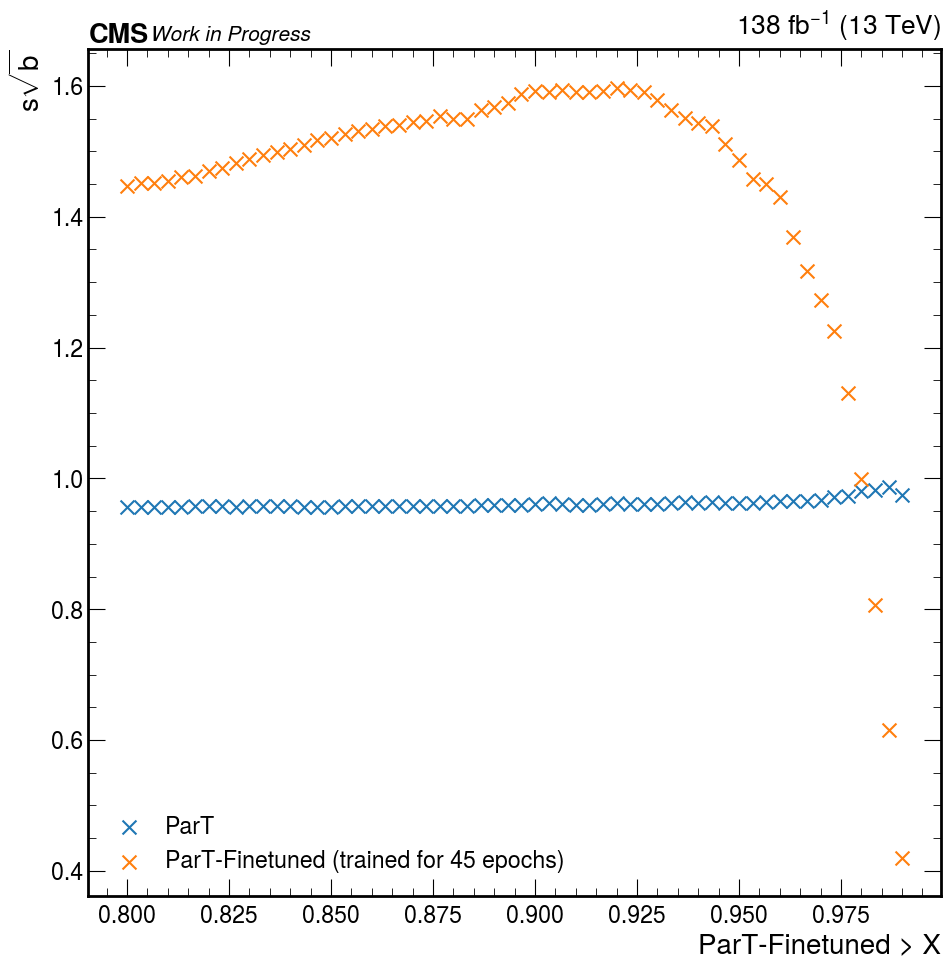

In [11]:
plt.rcParams.update({"font.size": 20})

nice_ch = {
    "ele": "Electron",
    "mu": "Muon",
}

fig, ax = plt.subplots(figsize=(11, 11))

taggers_to_plot = [
    "fj_ParT_score",
#     "fj_ParT_score_finetuned",
#     "fj_ParT_score_finetuned_v35_12_14",
    
#     "fj_ParT_score_finetuned_v35_16",
#     "fj_ParT_score_finetuned_v35_17",
#     "fj_ParT_score_finetuned_v35_20",
    
#     "fj_ParT_score_finetuned_v35_23",
    "fj_ParT_score_finetuned_v35_26",
#     "fj_ParT_score_finetuned_v35_29",
    
    
]
# taggers_to_plot = taggerss

for tagger in taggers_to_plot:   
    
    
    if tagger == "fj_ParT_score":
        lab = "ParT"
        col = "tab:orange"

    elif tagger == "fj_ParT_score_finetuned":
        lab = "ParT-Finetuned (current)"
        
#     elif tagger == "fj_ParT_score_finetuned_v35_16":
#         lab = "ParT-Finetuned (on 100k Signal)"
#     elif tagger == "fj_ParT_score_finetuned_v35_17":
#         lab = "ParT-Finetuned (on 100k Signal)"
#     elif tagger == "fj_ParT_score_finetuned_v35_18":
#         lab = "ParT-Finetuned (on 200k Signal)"
#     elif tagger == "fj_ParT_score_finetuned_v35_19":
#         lab = "ParT-Finetuned (on 200k Signal)"
        
#     elif tagger == "fj_ParT_score_finetuned_v35_20":
#         lab = "ParT-Finetuned (trained for 25 epochs)"
    elif tagger == "fj_ParT_score_finetuned_v35_23":
        lab = "ParT-Finetuned (trained for 35 epochs)"
    elif tagger == "fj_ParT_score_finetuned_v35_26":
        lab = "ParT-Finetuned (trained for 45 epochs)"
    elif tagger == "fj_ParT_score_finetuned_v35_29":
        lab = "ParT-Finetuned (trained for 55 epochs)"

    
    elif tagger == "fj_ParT_score_finetuned_v35_12_14 metcut":
        lab = "ParT-Finetuned (after MET cuts)"        
        
    else:
        lab = tagger
        col = "tab:blue"
        
    
    ax.scatter(tagger_cuts[:-3], s_over_b[tagger], marker="x", s=100, label=lab)#, c=col)

if len(channels)==1:
    lab = f"{nice_ch[channels[0]]} channel"
    if add_vbfcut:
        lab += " (VBF category)"
    if add_ggFcut:
        lab += " (ggF category)"        
    ax.legend(title=lab, loc="lower left")    
else:
    if add_vbfcut:
        lab = "VBF category"
    elif add_ggFcut:
        lab = "ggF category"
    else:
        lab = ""
    ax.legend(title=lab, loc="lower left")
ax.set_ylabel(r"$s\sqrt{b}$")
ax.set_xlabel("ParT-Finetuned > X")

# ax.axvline(0.895, linestyle="--", color="grey")
# ax.axvline(0.924, linestyle="--", color="grey")
# ax.axvline(0.91, linestyle="--", color="grey")
# ax.axvline(0.92, linestyle="--", color="grey")

# ax.set_ylim(0.5,2)
# ax.set_ylim(0.2,1.1)
# ax.set_xlim(0.78,0.95)

# ax.set_xticks(tagger_cuts)
hep.cms.lumitext("%.0f " % get_lumi(years, channels) + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15);
plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/soverb-new.pdf")

In [74]:
def fix_neg_yields(h):
    """
    Will set the bin yields of a process to 0 if the nominal yield is negative, and will
    set the yield to 0 for the full Systematic axis.
    """
    for sample in h.axes["samples"]:
        neg_bins = np.where(h[{"samples": sample}].values() < 0)[0]

        if len(neg_bins) > 0:
            print(f"{sample}, has {len(neg_bins)} bins with negative yield.. will set them to 0")

            sample_index = np.argmax(np.array(h.axes["samples"]) == sample)

            for neg_bin in neg_bins:
                h.view(flow=True)[sample_index, neg_bin + 1] = (0, 0)

In [213]:
vars_to_plot = [
#     "fj_msoftdrop",        
#     "rec_W_lnu_m",
#     "fj_pt",
#     "lep_pt",
#     "lep_eta",
    
#     "lep_fj_dr",
#     "lep_met_mt",
#     "met_fj_dphi",
#     "met_pt",    
    
#     "btag_1a",
#     "0btag_1b",
#     "1pbtag_1b",
    
#     "0btagT_btagSF",
#     "1plusbtagT_btagSF"
    
#     "rec_higgs_etajet_m",
#     "fj_ParT_mass",
#     "fj_ParT_score_finetuned"
    
    "rec_higgs_m",    
    # AN
#     "FirstFatjet_pt",
#     "SecondFatjet_pt",
#     "fj_pt",
#     "lep_pt",
#     "NumFatjets",
#     "NumOtherJets",
#     "lep_fj_dr",
#     "met_pt",
#     "met_fj_dphi",
#     "lep_met_mt",    
#     "ht",
#     "fj_mass",
#     "rec_W_qq_m",
#     "rec_W_lnu_m",    
#     "fj_lsf3",
    
#     "lep_isolation",
#     "lep_isolation_ele",
#     "lep_isolation_ele_highpt",
#     "lep_isolation_ele_lowpt",
    
#     "lep_isolation_mu",
#     "lep_isolation_mu_highpt",
#     "lep_isolation_mu_lowpt",   
    
#     "lep_misolation",
#     "lep_misolation_highpt",
#     "lep_misolation_lowpt",    
]

samples_to_plot = [
    "ggF", 
    "VBF",
#     "ttH",
#     "WH",
#     "ZH",    
    "QCD",
#     "DYJets",
    "WJetsLNu",
    
#     "WJetsLNu_unmatched",
#     "WJetsLNu_matched",

#     "WZQQ",
    "TTbar",
    "SingleTop",
    "Diboson",
    "EWKvjets",
    "Data",
    
    "WZQQorDYJets"
]

In [214]:
# tagger = "fj_ParT_score"
# tagger = "fj_ParT_score_finetuned"
# tagger_cut = 0.97   # VBF
# tagger_cut = 0.975  # ggF

tagger = "fj_ParT_score_finetuned_v35_12_14"
tagger = "fj_ParT_score_finetuned_v35_20"

# tagger_cut = 0.88   # VBF
tagger_cut = 0.91  # ggF

# tagger_cut = 0.895  # ggF

presel = {
#     "Pre-selection": f"fj_pt>0",   # dummy
    "SR": f"({tagger}>{tagger_cut}) & (n_bjets_T==0)",   # dummy
    
#     "SR": f"{tagger}>0.965",
#     "SR": f"{tagger}>{tagger_cut}",    
    
#     "Pre-selection": f"(fj_ParT_score_finetuned>0.95) & (fj_msoftdrop>10)",   # dummy    
    
#     "Pre-selection": f"met_pt>100 & ({tagger}<0.5) & n_bjets_T>0",   # dummy    
#     "Pre-selection": f"met_pt>100 & n_bjets_T>0",   # dummy    

#     "Pre-selection": f"met_pt>100 & n_bjets_L==0 & {tagger}>0.5 & {tagger}<0.97",   # dummy    
    
#     "Pre-selection": f"met_pt>20",

#     "SR": f"({tagger}>0.98) & (n_bjets_T==0)",    
    
#     "SR2": f"({tagger}>0.97) & ({tagger}<0.98) & (n_bjets_T==0)",
#     "WJets CR": f"({tagger}<0.88) & ({tagger}>0.70) & (n_bjets_T==0) & (met_pt>100)",
#     "Top CR": f"({tagger}>0.8) & (n_bjets_T>0)",
}

categories_sel = {
#     "VBF": f"( (fj_ParT_score_finetuned>{tagger_cut}) & (n_bjets_T==0) ) & ( (mjj>1000) & (deta>3.5) )",
#     rf"ggF": "(mjj<1000) | (deta<3.5)",
        
#     r"ggF pT [250, 300]": f"( (fj_ParT_score_finetuned>{tagger_cut}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (fj_pt>250) & (fj_pt<300) )",
#     f"ggF pT [300, 450]": f"( (fj_ParT_score_finetuned>{tagger_cut}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (fj_pt>300) & (fj_pt<450) )",
#     r"ggF pT [450, Inf]": f"( (fj_ParT_score_finetuned>{tagger_cut}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (fj_pt>450) )",
}

channels = ["ele", "mu"]
# channels = ["mu"]
years = ["2018", "2017", "2016", "2016APV"]
years = ["2018"]

num, den = 0, 0
threshold = 0

# fill histograms
hists = {}

# ev = events_dict["new_correctionsNOTAGGER"]

ev = events_dict
# ev = events_dict["wjetsNLO"]

# ev = events_dict["new_correctionsNODPHI"]

MET_cut = False
import utils

massbin = 10
if "VBF" in categories_sel:
    massbin = 20

for var in vars_to_plot:

    if var == "rec_higgs_m":
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            hist2.axis.Variable(list(range(55, 255, massbin)), name="var", label=r"Higgs reconstructed mass [GeV]", overflow=True),
            storage=hist2.storage.Weight(),            
        )       
    else:
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            utils.axis_dict[var],
            storage=hist2.storage.Weight(),            
        )        
        
    for sample in samples_to_plot:
        for year in years:
            for ch in channels:
            
                region, sel = list(presel.items())[0]
                
                df = ev[year][ch][sample]
                
                df = df.query(sel)
                    
                if "MET>X" in region:
                    MET_cut = 100
                    df = df[df["met_pt"]>MET_cut]
                                
                if len(categories_sel)>=1:
                    category, category_sel = list(categories_sel.items())[0]
                    df = df.query(category_sel)
            
                if sample == "QCD":
                    threshold = 30
                    den += len(df['event_weight'])
                    num += sum(df["event_weight"]>threshold)

                    df = df[df["event_weight"] < threshold]
                
                x = df[var]
                w = df["event_weight"]
                
                hists[var].fill(
                    samples=sample,
                    var=x,
                    weight=w,
                )     
try:
    print(f"Removing {num} out of {den} qcd events by applying event_weight<{threshold} ({(100*num/den):.2f}%)")
except:
    z=1
    
for var in vars_to_plot:
    fix_neg_yields(hists[var])

Removing 0 out of 11 qcd events by applying event_weight<30 (0.00%)
WZQQorDYJets, has 1 bins with negative yield.. will set them to 0


Will plot rec_higgs_m histogram


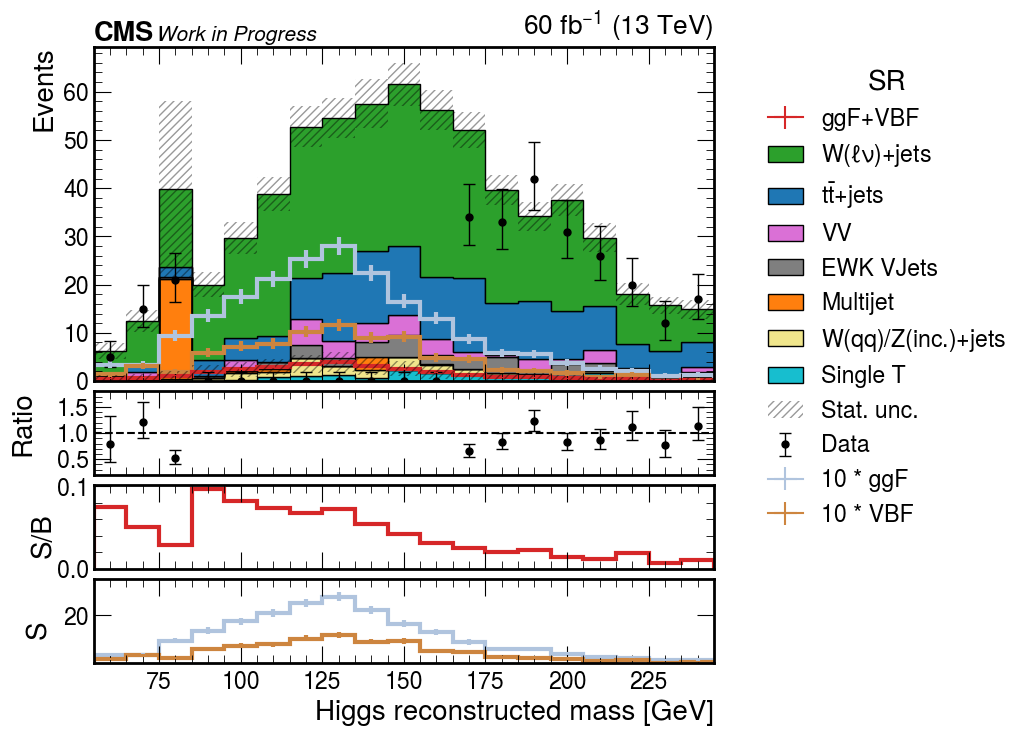

In [215]:
plt.rcParams.update({"font.size": 20})
add_data = True

if "SR" in region or ("Signal region") in region:
    add_soverb=True
    blind_region=[90,160]
    if "SR1" in region:
        mult=10
    else:
        mult=10
else:
    add_soverb=True
    blind_region=False
    mult=10
    
if "VBF" in categories_sel:
    mult = 5
    
    
from utils import plot_hists
if len(years) > 1:
    from utils import plot_hists
    PATH = f"/Users/fmokhtar/Desktop/AN_2024/preselection_Run2/"
    PATH = f"/Users/fmokhtar/Desktop/AN_2024/SignalRegion/"

#     PATH = f"/Users/fmokhtar/Desktop/AN_2024/sig_region_{list(categories_sel.keys())[0]}_Run2/"
else:
    from utils import plot_hists_sb as plot_hists
    PATH = f"/Users/fmokhtar/Desktop/AN_2024/preselection_{years[0]}/"
#     PATH = f"/Users/fmokhtar/Desktop/AN_2024/sig_region_{list(categories_sel.keys())[0]}_{years[0]}/"

PATH = f"/Users/fmokhtar/Desktop/AN_2024/lol/"
# from utilsF import plot_hists

if not os.path.exists(PATH):
    # Create the directory
    os.makedirs(PATH)    

plot_hists(hists, years, channels, vars_to_plot,             
            add_data=add_data,
            logy=False,
            add_soverb=add_soverb,
            only_sig=False,
            mult=mult,
            outpath=PATH,
            text_=region,
#             text_=region + f"\n {list(categories_sel.keys())[0]} category",
#             text_=region + f"\n category: {list(categories_sel.keys())[0]} \n Applying qcd event_weight<{threshold}",
#             text_=region + f"\n Applying qcd event_weight<{threshold}",

            blind_region=blind_region,
#            save_as=f"{years[0]}_{channels[0]}"
#            save_as=f"{ch}"
           
          )
# print()
# get_soverb(ev, tagger, presel, categories_sel, years, channels, threshold=threshold, MET_cut=MET_cut)

In [64]:
hists

{'rec_higgs_m': Hist(
   StrCategory(['ggF', 'VBF', 'ttH', 'WH', 'ZH', 'QCD', 'WJetsLNu', 'TTbar', 'SingleTop', 'Diboson', 'EWKvjets', 'Data', 'WZQQorDYJets'], growth=True, name='samples'),
   Variable([45, 55, 65, 75, 85, 95, 105, 115, 125, 135, 145, 155, 165, 175, 185, 195, 205, 215, 225, 235], name='var', label='Higgs reconstructed mass [GeV]'),
   storage=Double()) # Sum: 1038.332692342047 (1172.7765295977254 with flow)}

In [298]:
hists["rec_higgs_m"][{"samples": sum}].values()[0:2]

array([0.13706524, 2.00155444])

In [463]:
# VBFele + VBFmu + ggF_ele + ggF_mu
(0.75**2 + 1.13**2 + 0.68**2 + 1.02**2)**0.5

1.8281684823888633

In [464]:
# VBF + ggF
(1.35**2 + 1.21**2)**0.5

1.81289823211343

In [471]:
(0.82**2 + 1.24**2)**0.5

1.4866068747318506

In [89]:
dominant_backgrounds = ["WJetsLNu", "TTbar", "QCD", "WZQQorDYJets"]
def get_soverb(ev, tagger, presel, categories_sel, years, channels, MET_cut=False, misocut=None, threshold=None):

    mass_window = [100, 150]

    num_sig = {
        "ggF": 0, 
#         "ttH": 0, 
#         "VH": 0,
        "VBF": 0,
    }
    num_bkg = {
        "WJetsLNu": 0, 
        "TTbar": 0, 
        "QCD": 0,
        "WZQQorDYJets": 0,
        "Others": 0,
    }

    deno_sig, deno_bkg = 0, 0
    s, b = 0, 0

    samples = [
        "ggF", 
        "VBF",
        "ttH",
        "WH",
        "ZH",        
        "QCD",
#         "DYJets",
        "WJetsLNu",
#         "WZQQ",
        "TTbar",
        "SingleTop",
        "Diboson",
        "Data",
        "WZQQorDYJets",
    ]

    for year in years:
        for ch in channels:
            for sample in samples:
                if sample=="Data":
                    continue

                region, sel = list(presel.items())[0]

                df = ev[year][ch][sample]

                df = df.query(sel)  

                for category, category_sel in categories_sel.items():
                    df = df.query(category_sel)

                if MET_cut:
                    df = df[df["met_pt"]>MET_cut]
                    
                if threshold:
                    if sample == "QCD":
                        df = df[df["event_weight"] < threshold]
    
                ######################## composition start
                if sample in utils.signals:

                    deno_sig += df["event_weight"].sum()
                    num_sig[sample] += df["event_weight"].sum()
                else:
                    deno_bkg += df["event_weight"].sum()

                    if sample in dominant_backgrounds:
                        num_bkg[sample] += df["event_weight"].sum()
                    else:
                        num_bkg["Others"] += df["event_weight"].sum()     
                ######################## composition end

                ######################## soverb start
                df = df[(df["rec_higgs_m"]>=mass_window[0]) & (df["rec_higgs_m"]<=mass_window[1])]

                if sample in utils.signals:                
                    s += df["event_weight"].sum()
                else:
                    b += df["event_weight"].sum()
                ######################## soverb end

    num_sig = dict(sorted(num_sig.items(), key=lambda item: item[1]))
    num_bkg = dict(sorted(num_bkg.items(), key=lambda item: item[1]))

    if len(years) == 4:
        lab = "RUN2"
    else:
        lab = "_".join(years)

    print("\033[1m" + f"{list(presel.keys())[0]} ({lab}):" + '\033[0m')
    if len(list(categories_sel.items()))!=0:
        print("Category:", list(categories_sel.keys())[0])

    print("------------------------")

    if "SR" in list(presel.keys())[0]:
        print("\033[1m" + rf"s/sqrt(b) in [{mass_window[0]},{mass_window[1]}]: {s/math.sqrt(b):.2f}" + '\033[0m')
        print("------------------------")

    print(f"Signal: {deno_sig:.2f}")
    for sample in num_sig:
        print(f"- {sample}: {100*(num_sig[sample]/deno_sig):.0f}%")

    print("------------------------")
    print(f"Background: {deno_bkg:.2f}")
    for sample in num_bkg:
        if sample=="":
            print("\033[1m" + f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.0f}%")
        else:
            print(f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.0f}%")             

In [ ]:
fig, ax = plt.subplots(figsize=(9,8))

bins = np.linspace(45,210,20)

syst = "UES_down"


a = ax.hist(df["rec_higgs_m"], label="Nominal", weights=df["weight_ele"],
        bins=bins, lw=2, histtype="step", 
       )

d = ax.hist(df[f"rec_higgs_m{syst}"], label="down", weights=df["weight_ele"],
        bins=bins, lw=2, histtype="step", 
       )

# w = (df[f"rec_higgs_m{syst}"]/df["rec_higgs_m"])
# ax.hist(df[f"rec_higgs_m"], label="(should be down)", weights=df["weight_ele"] * w,
#         bins=bins, lw=1, histtype="step", 
#        )

ax.legend()
ax.set_xlabel("Higgs reconstructed mass [GeV]")
ax.set_ylabel("ggHWW events")
#         plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/JMSR/weight_{ch}_{syst}.pdf")